In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

In [117]:
# Load Dataset
df = pd.read_csv("data/10sec_100_m_flow_speed_1hr.csv")
df['quarter'] = pd.qcut(df['Space'], q=4, labels=[1, 2, 3, 4])

print(df)

                               Time     Space       Flow    Density quarter
0     2022-11-30 14:00:00.400000095  98170.01   182.8080  26.519997       1
1     2022-11-30 14:00:00.400000095  98270.01  1026.7020  57.319997       1
2     2022-11-30 14:00:00.400000095  98370.01  1411.0020  46.519995       1
3     2022-11-30 14:00:00.400000095  98470.01   466.5600   6.199999       1
4     2022-11-30 14:00:00.400000095  98570.01   717.8184  15.399998       2
...                             ...       ...        ...        ...     ...
5755  2022-11-30 14:59:50.400000095  99270.01   522.0216   7.119999       3
5756  2022-11-30 14:59:50.400000095  99370.01   918.4284  15.919998       4
5757  2022-11-30 14:59:50.400000095  99470.01  1453.2300  25.719997       4
5758  2022-11-30 14:59:50.400000095  99570.01  1130.8536  18.639997       4
5759  2022-11-30 14:59:50.400000095  99670.01  1675.5120  27.439995       4

[5760 rows x 5 columns]


In [118]:
rho_hat = df["Density"]
q_hat = df["Flow"]
C_i = np.mean(sorted(q_hat)[-5:])
print("C_i", C_i)
K = len(rho_hat)

C_i 7423.076159999922


In [119]:
model = ConcreteModel()
model.k = RangeSet(0, K - 1)

# Data parameters
model.rho_hat = Param(model.k, initialize={k: rho_hat[k] for k in range(K)})
model.q_hat = Param(model.k, initialize={k: q_hat[k] for k in range(K)})
model.C = Param(initialize=C_i)  # FIXED

# Variables to optimize
model.rho_crit = Var(bounds=(1e-2, max(rho_hat)), initialize=np.median(rho_hat))
model.V_free = Var(bounds=(10, 150), initialize=60)
model.a = Var(bounds=(0.01, 10), initialize=1.0)

# Smoothed piecewise flow function
def q_pred_expr(model, k):
    rho = model.rho_hat[k]
    rho_crit = model.rho_crit
    V_free = model.V_free
    a = model.a
    Q = rho * V_free * exp(-1/a * (rho/rho_crit)**a)
    return Q

model.q_pred = Expression(model.k, rule=q_pred_expr)

# Objective function
def obj_rule(model):
    return sum((model.q_pred[k] - model.q_hat[k])**2 for k in model.k)

model.obj = Objective(rule=obj_rule, sense=minimize)
print("Initial guess:")
print(f"rho_crit = {value(model.rho_crit)}")
print(f"V_free = {value(model.V_free)}")
print(f"a = {value(model.a)}")

# Solve
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)

# Output
print("Optimized Parameters:")
print(f"rho_crit = {value(model.rho_crit):.3f}")
print(f"V_free = {value(model.V_free):.3f}")
print(f"a = {value(model.a):.3f}")

Initial guess:
rho_crit = 88.17999049999999
V_free = 60
a = 1.0
Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number

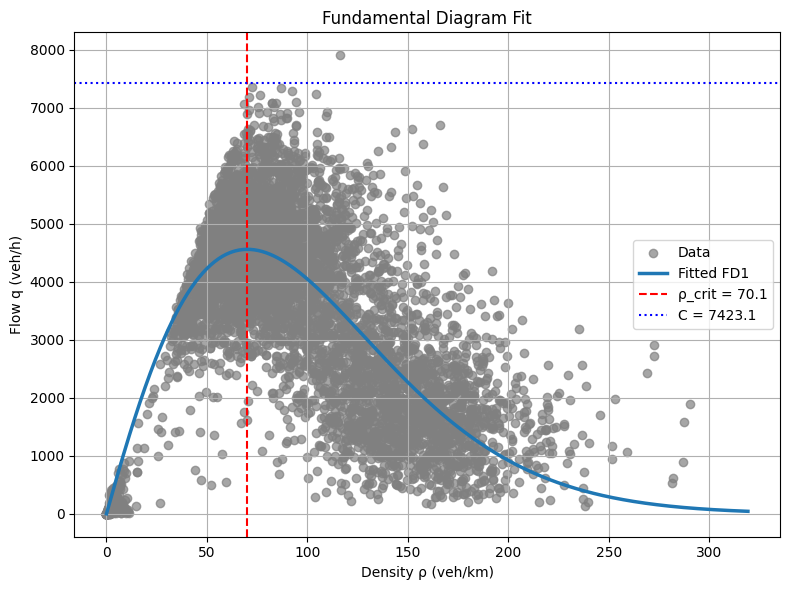

In [120]:
rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)
C = np.mean(sorted(q_hat)[-5:])  # same C you used in Pyomo

# Define Q(rho) using the original piecewise FD1
def Q_fd1(rho):
    rho = np.array(rho)
    Q_free = V_free * rho * np.exp(-1/a * (rho / rho_crit)**a)
    # Q = np.where(rho <= rho_crit, Q_free, C)
    Q = Q_free
    return Q

# Generate smooth rho values for curve
rho_range = np.linspace(0, max(rho_hat)*1.1, 500)
q_fit = Q_fd1(rho_range)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7, label='Data')
plt.plot(rho_range, q_fit, linewidth=2.5, label='Fitted FD1', zorder=10)
plt.axvline(rho_crit, color='red', linestyle='--', label=f'ρ_crit = {rho_crit:.1f}')
plt.axhline(C, color='blue', linestyle=':', label=f'C = {C:.1f}')
plt.xlabel("Density ρ (veh/km)")
plt.ylabel("Flow q (veh/h)")
plt.title("Fundamental Diagram Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [121]:
# Calculate flow and speed for 100 meter segments
MILE_MARKER_61 = 98170  # meters
# MILE_MARKER_62 = 99779.3  # meters
MILE_MARKER_62 = 99770  # meters
SPEED_LIMIT = 112.654  # km/h = 70 mph
l = 100  # meters
lanes = 4
space_segments = np.arange(MILE_MARKER_61, MILE_MARKER_62, l)  # 100 meter segments
time_segments = np.arange(0, 3600, 10)  # 10 second intervals
min_time = pd.to_datetime("2022-11-30 13:00:00.400000095")
max_time = min_time + pd.Timedelta(seconds=3600)
T = 360

# Parameters we have to optimize for
# tau = None
# eta_high = None
# eta_low = None
# K = None

metanet_space_segments = space_segments[1:-1]
print(len(metanet_space_segments))
new_model = ConcreteModel()
new_model.k = RangeSet(0, K - 1)
new_model.tau = Var(bounds=(0.0, 40), initialize=18.0)
new_model.eta_high = Var(bounds=(30, 100), initialize=1.0)
new_model.eta_low = Var(bounds=(30, 100), initialize=1.0)
new_model.timesteps = RangeSet(0, T - 1)
new_model.space_segments = RangeSet(0, len(metanet_space_segments)-1)


14
WARNING (W1002): Setting Var 'eta_high' to a numeric value `1.0` outside the
bounds (30, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'eta_low' to a numeric value `1.0` outside the
bounds (30, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


In [122]:
from pyomo.environ import Expr_if

# Use first and last segment as boundary conditions

# First reshape rho_hat to be a numpy array of shape (num_time_intervals, num_segments)
rho_hat_reshaped = np.zeros((len(time_segments), len(space_segments)-2))
print(rho_hat_reshaped.shape)
print(rho_hat.shape)
for i in range(len(time_segments)):
    for j in range(1, len(space_segments)-1):
        rho_hat_reshaped[i, j-1] = rho_hat[i * len(space_segments) + (j)]
zero_mask = np.where(rho_hat_reshaped == 0)
rho_hat_reshaped[zero_mask] = 1e-3
new_model.rho_hat = rho_hat_reshaped
# sort q_hat by time and space
q_hat = df["Flow"]
q_hat_reshaped = np.zeros((len(time_segments), len(space_segments)-2))
for i in range(len(time_segments)):
    for j in range(1, len(space_segments)-1):
        q_hat_reshaped[i, j-1] = q_hat[i * len(space_segments) + (j)]
print(np.max(q_hat_reshaped))
new_model.q_hat = q_hat_reshaped
print(np.max(rho_hat_reshaped))
new_model.v_hat = q_hat_reshaped / (rho_hat_reshaped * lanes)
flow_origin = np.zeros((len(time_segments), 1))
flow_origin = q_hat_reshaped[:, 0:1]

downstream_density = np.zeros((len(time_segments), 1))
downstream_density = rho_hat_reshaped[:, -1:]

# Define the prediction of flow, density, and speed for the new model
# copied from another place, need to adapt for model
def density_dynamics(current, inflow, outflow, lanes, T, l):
    return current + T/(l * lanes) * (inflow - outflow)

def flow_dynamics(density, velocity, lanes):
    # if density * velocity > q_capacity:
    #     print(density, velocity, lanes)
    return density * velocity * lanes

def queue_dynamics(current, demand, flow_origin, T):
    return current + T * (demand - flow_origin)

def calculate_V(rho, v_ctrl):
    expr = V_free * exp(-1 / a * (rho / rho_crit)**a)
    return Expr_if(expr <= v_ctrl, expr, v_ctrl)

def velocity_dynamics(current, prev_state, density, next_density, current_density, v_ctrl, T, l, tau, eta_high):
    next_v = current \
        + T / tau * (calculate_V(density, v_ctrl) - current) \
        + T / l * current * (prev_state - current) \
        - (eta_high * T) / (tau * l) * (next_density - density) / (density + K)
    return Expr_if(next_v >= 0, next_v, 0)
def model_dynamics(new_model):
    num_segments = len(space_segments) - 2
    v_pred = new_model.v_pred
    rho_pred = new_model.rho_pred
    q_pred = new_model.q_pred

    for i in range(rho_hat_reshaped.shape[1]):
        rho_pred[0, i] = rho_hat_reshaped[0, i]
        q_pred[0, i] = q_hat_reshaped[0, i]
        v_pred[0, i] = q_hat_reshaped[0, i] / (rho_hat_reshaped[0, i] * lanes)

    for t in range(len(time_segments)-1):
        for i in range(num_segments):
            
            if i == 0:
                print("t:", t)
                print("i:", i)
                print("infow", value(flow_origin[t, 0]))
                print("outflow", value(q_pred[t, i]))
                print("Current density", value(rho_pred[t,i]))
                print("T", T)
                print("l", l/1000)
                rho_pred[t+1, i] = density_dynamics(rho_pred[t, i], flow_origin[t, 0], q_pred[t, i], 4, T, l/1000)
            else:
                rho_pred[t+1, i] = density_dynamics(rho_pred[t, i], q_pred[t, i-1], q_pred[t, i], 4, T, l/1000)
        # Update velocity
        for i in range(num_segments):
            if i == 0:
                print("v_pred", value(v_pred[t,i]))
                print("rho_pred[t, i]", value(rho_pred[t, i]))
                print("rho_pred[t, i+1]", value(rho_pred[t, i+1]))
                print("rho_pred[t+1, i]", value(rho_pred[t+1, i]))
                v_pred[t+1, i] = velocity_dynamics(v_pred[t, i], v_pred[t,i], rho_pred[t, i], rho_pred[t, i+1], rho_pred[t+1, i], SPEED_LIMIT, T, l/1000, new_model.tau, new_model.eta_high)
            elif i == num_segments-1:
                v_pred[t+1, i] = velocity_dynamics(v_pred[t, i], v_pred[t, i-1], rho_pred[t, i], downstream_density[t], rho_pred[t+1, i], SPEED_LIMIT, T, l/1000, new_model.tau, new_model.eta_high)
            else:
                v_pred[t+1, i] = velocity_dynamics(v_pred[t, i], v_pred[t, i-1], rho_pred[t, i], rho_pred[t, i+1], rho_pred[t+1, i], SPEED_LIMIT, T, l/1000, new_model.tau, new_model.eta_high)
        # Update flow
        for i in range(num_segments):
            if i ==0:
                print("density", value(rho_pred[t+1, i]))
                print("velocity",value(v_pred[t+1, i]))
            q_pred[t+1, i] = flow_dynamics(rho_pred[t+1, i], v_pred[t+1, i], lanes)
    return rho_pred, v_pred, q_pred

(360, 14)
(5760,)
7902.878400000021
290.23999000000003


In [124]:
# Run the model and solve for the optimized parameters 
p_max = 10000
q_capacity = 10000
new_model.rho_pred = Var(new_model.timesteps, new_model.space_segments, bounds=(1e-3, p_max))
new_model.v_pred = Var(new_model.timesteps, new_model.space_segments, bounds=(0, SPEED_LIMIT))
new_model.q_pred = Var(new_model.timesteps, new_model.space_segments, bounds=(0, q_capacity))
num_segments = 14
# Define the objective function as the sum of squared differences of rho_hat and rho_pred and v_hat and v_pred
def obj_rule(new_model):
    rho_pred, v_pred, q_pred = model_dynamics(new_model)
    error = 0
    for t in range(len(time_segments)-1):
        for i in range(num_segments):
            error += (rho_pred[t, i] - new_model.rho_hat[t, i])**2 + (v_pred[t, i] - new_model.v_hat[t, i])**2
    return error

new_model.obj = Objective(rule=obj_rule, sense=minimize)

solver = SolverFactory('ipopt')
solver.solve(new_model, tee=True)



'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_com

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



WARNING (W1001): Setting Var 'q_pred[287,9]' to a value `nan` (float64) not in
domain Reals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'q_pred[287,10]' to a value `nan` (float64) not
in domain Reals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'q_pred[287,11]' to a value `nan` (float64) not
in domain Reals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'q_pred[287,12]' to a value `nan` (float64) not
in domain Reals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
WARNING (W1001): Setting Var 'q_pred[287,13]' to a value `nan` (float64) not
in domain Reals.
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1001
t: 287
i: 0
infow 5019.372000000015
outflow nan
Current density nan
T 360
l 0.1
WARNING (W1001): Setting Var 'rho_pred[288,0]' to a value `nan` (float64) not
in domain Reals.
    Se

ValueError: Cannot load a SolverResults object with bad status: error

In [132]:
# Calculate flow and speed for 100 meter segments
MILE_MARKER_61 = 98170  # meters
# MILE_MARKER_62 = 99779.3  # meters
MILE_MARKER_62 = 99770  # meters
SPEED_LIMIT = 112.654  # km/h = 70 mph
l = 100  # meters
lanes = 4
space_segments = np.arange(MILE_MARKER_61, MILE_MARKER_62, l)  # 100 meter segments
time_segments = np.arange(0,3600, 10)

T = 10/3600
l = 0.1
SPEED_LIMIT = 120 # KM/H

rho_hat = np.zeros((len(time_segments), len(space_segments)))
q_hat = np.zeros((len(time_segments), len(space_segments)))
for t in range(len(time_segments)):
    for i in range(len(space_segments)):
        rho_hat[t,i] = df["Density"][t*len(space_segments) + i]
        if rho_hat[t,i] == 0:
            rho_hat[t,i] = 1e-3
        q_hat[t,i] = df["Flow"][t*len(space_segments) + i]
v_hat = q_hat/ (rho_hat*lanes)

flow_origin = q_hat[:, 0:1]
downstream_density = rho_hat[:,-1:]

model = ConcreteModel()
model.timesteps = RangeSet(0, len(time_segments)-1)
model.space_segments = RangeSet(0, len(space_segments)-3)

p_max = 10000
q_capacity = 10000

In [133]:
model.rho_hat = Param(model.timesteps, model.space_segments, initialize=lambda m, t, i: float(rho_hat[t, i]))
model.v_hat = Param(model.timesteps, model.space_segments, initialize=lambda m, t, i: float(v_hat[t, i]))

model.rho_pred = Var(model.timesteps, model.space_segments, bounds=(1e-3, p_max))
model.v_pred = Var(model.timesteps, model.space_segments, bounds=(0, SPEED_LIMIT))
model.q_pred = Var(model.timesteps, model.space_segments, bounds=(0, q_capacity))

# Parameters to find
model.tau = Param(initialize=18/3600)
model.eta_high = Param(initialize=30)
model.K = Param(initialize = 40)

In [134]:
def init_conditions(m, i):
    return m.rho_pred[0, i] == m.rho_hat[0, i]
model.init_rho = Constraint(model.space_segments, rule=init_conditions)

def init_flow(m, i):
    return m.q_pred[0, i] == m.rho_hat[0, i] * m.v_hat[0, i] * lanes
model.init_q = Constraint(model.space_segments, rule=init_flow)

def init_speed(m, i):
    return m.v_pred[0, i] == m.v_hat[0, i]
model.init_v = Constraint(model.space_segments, rule=init_speed)

In [137]:
def rho_update(m, t, i):
    if t == 0:
        return Constraint.Skip
    inflow = flow_origin[t-1, 0] if i == 0 else m.q_pred[t-1, i-1]
    outflow = m.q_pred[t-1, i]
    return m.rho_pred[t, i] == m.rho_pred[t-1, i] + T / (l * lanes) * (inflow - outflow)
model.rho_dyn = Constraint(model.timesteps, model.space_segments, rule=rho_update)

def V_eq(m, rho):
    return V_free * exp(-1 / a * (rho / rho_crit)**a)

def v_update(m, t, i):
    if t == 0:
        return Constraint.Skip
    prev_v = m.v_pred[t-1, i-1] if i > 0 else m.v_pred[t-1, i]
    next_rho = downstream_density[t-1, 0] if i == len(space_segments)-3 else m.rho_pred[t-1, i+1]
    return m.v_pred[t, i] == m.v_pred[t-1, i] \
        + T / m.tau * (V_eq(m, m.rho_pred[t-1, i]) - m.v_pred[t-1, i]) \
        + T / l * m.v_pred[t-1, i] * (prev_v - m.v_pred[t-1, i]) \
        - (m.eta_high * T) / (m.tau * l) * (next_rho - m.rho_pred[t-1, i]) / (m.rho_pred[t-1, i] + m.K)
model.v_dyn = Constraint(model.timesteps, model.space_segments, rule=v_update)

def q_update(m, t, i):
    if t == 0:
        return Constraint.Skip
    return m.q_pred[t, i] == m.rho_pred[t, i] * m.v_pred[t, i] * lanes
model.q_dyn = Constraint(model.timesteps, model.space_segments, rule=q_update)

# Objective
def obj_rule(m):
    return sum((m.rho_pred[t, i] - m.rho_hat[t, i])**2 + (m.v_pred[t, i] - m.v_hat[t, i])**2
               for t in m.timesteps for i in m.space_segments if t != 0)
model.obj = Objective(rule=obj_rule, sense=minimize)


'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


In [ ]:
for t in model.timesteps:
    for i in model.space_segments:
        model.rho_pred[t, i].set_value(float(rho_hat[t, i]))
        model.v_pred[t, i].set_value(float(v_hat[t, i]))
        model.q_pred[t, i].set_value(float(rho_hat[t, i]) * float(v_hat[t, i]) * lanes)


solver = SolverFactory('ipopt')
solver.options['max_iter'] = 5000
solver.options['tol'] = 1e-6
result = solver.solve(model, tee=True, skip_trivial_constraints=True, load_solutions=False)

Ipopt 3.14.17: max_iter=5000
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    59277
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    24439

Total number of variables............................:    15120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    15120
                     variables with only upper bounds:        0
Total number of equality constraints................